<a href="https://colab.research.google.com/github/trantoan62/AI_FinalReport/blob/main/Training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall h5py -y
!pip install h5py==2.10.0
!pip uninstall numpy -y
!pip install numpy==1.16.4
!pip uninstall scikit-image -y
!pip install scikit-image==0.16.2
!pip install --no-deps tensorflow==1.15.3
!pip install --no-deps keras==2.2.4

In [ ]:
 !git clone https://github.com/matterport/Mask_RCNN.git
 %cd Mask_RCNN
!pip install -r requirements.txt
!python setup.py install
%cd ..

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [ ]:
class CowDataset(Dataset):
  def load_dataset(self, dataset_dir, is_train=True):
    self.add_class("dataset", 1, "cow")
    images_dir = dataset_dir + '/data/'
    annotations_dir = dataset_dir + '/label/'
    for filename in listdir(images_dir):
      image_id = filename[4:-6]
      if is_train and int(image_id) >= 81:
        continue
      if not is_train and ( int(image_id) < 81 or int(image_id) >= 101):
        continue
      if int(image_id) >= 101:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + 'cow(' + image_id + ').xml'
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      
  def extract_boxes(self, filename):
      tree = ElementTree.parse(filename)
      root = tree.getroot()
      boxes = list()
      for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
      width = int(root.find('.//size/width').text)
      height = int(root.find('.//size/height').text)
      return boxes, width, height

  def load_mask(self, image_id):
      info = self.image_info[image_id]
      path = info['annotation']
      boxes, w, h = self.extract_boxes(path)
      masks = zeros([h, w, len(boxes)], dtype='uint8')
      class_ids = list()
      for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index('cow'))
      return masks, asarray(class_ids, dtype='int32')
      
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_set = CowDataset()
train_set.load_dataset('/content/drive/MyDrive/cow', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 80


In [ ]:
test_set = CowDataset()
test_set.load_dataset('/content/drive/MyDrive/cow', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 20


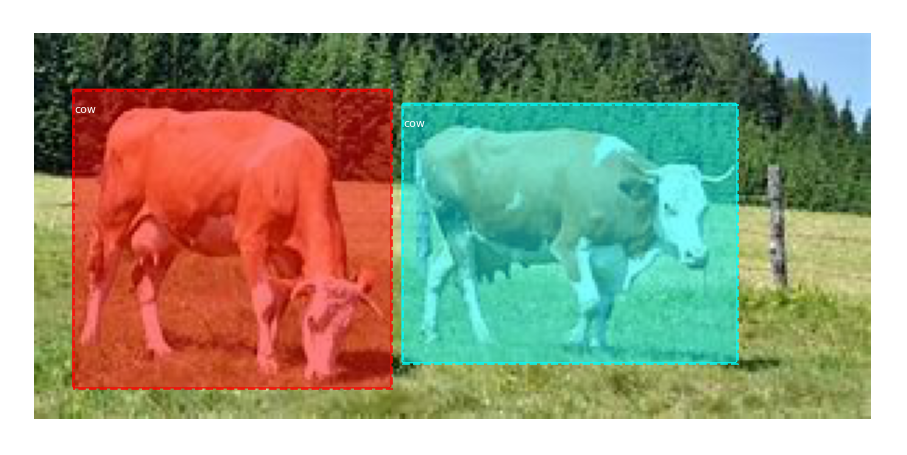

In [ ]:
image_id = 5
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
class CowConfig(Config):
	NAME = "cow_cfg"
	NUM_CLASSES = 2
	STEPS_PER_EPOCH = 80

In [ ]:
config = CowConfig()

In [ ]:
%cd /content/drive/MyDrive
model = MaskRCNN(mode='training', model_dir='./', config=config)

/content/drive/MyDrive


In [ ]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')








Starting at epoch 0. LR=0.001

Checkpoint Path: ./cow_cfg20220621T1835/mask_rcnn_cow_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
80/80 [==============================] - 10546s 132s/step - loss: 1.4742 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2855 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.5240 - mrcnn_mask_loss: 0.4696 - val_loss: 1.0720 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 0.2235 - val_mrcnn_class_loss: 0.1567 - val_mrcnn_bbox_loss: 0.3914 - val_mrcnn_mask_loss: 0.2900

Epoch 2/5
80/80 [==============================] - 10340s 129s/step - loss: 1.0119 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2470 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.3123 - val_loss: 0.9130 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.2322 - val_mrcnn_class_loss: 0.1369 - val_mrcnn_bbox_loss: 0.2665 - val_mrcnn_mask_loss: 0.2677
Epoch 3/5
24/80 [========>.....................] - ETA: 1:40:53 - loss: 0.8643 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1877 - mrcnn_class_loss: 0.1563 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.2850

In [ ]:
config = CowConfig()

In [ ]:
%cd /content/drive/MyDrive
model2 = MaskRCNN(mode='training', model_dir='./', config=config)

/content/drive/MyDrive






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model2.load_weights('mask_rcnn_cow_cfg_0002.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model2.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=3, layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: ./cow_cfg20220622T0152/mask_rcnn_cow_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDist

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/3
80/80 [==============================] - 10152s 127s/step - loss: 1.6022 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.4235 - mrcnn_mask_loss: 0.7524 - val_loss: 1.0207 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.2566 - val_mrcnn_class_loss: 0.1202 - val_mrcnn_bbox_loss: 0.3218 - val_mrcnn_mask_loss: 0.3125

Epoch 2/3
80/80 [==============================] - 9991s 125s/step - loss: 0.8956 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.3111 - val_loss: 0.9202 - val_rpn_class_loss: 0.0122 - val_rpn_bbox_loss: 0.2829 - val_mrcnn_class_loss: 0.1339 - val_mrcnn_bbox_loss: 0.2209 - val_mrcnn_mask_loss: 0.2702
Epoch 3/3
80/80 [==============================] - 10024s 125s/step - loss: 0.7873 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.2972 - val_loss: 0.9043 - val_rpn_cl

In [ ]:
class PredictionConfig(Config):
	NAME = "cow_cfg"
	NUM_CLASSES = 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	mAP = mean(APs)
	return mAP

In [ ]:
cfg = PredictionConfig()
%cd /content/drive/MyDrive
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('mask_rcnn_cow_cfg_0003.h5', by_name=True)
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

/content/drive/MyDrive







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Train mAP: 0.715
Test mAP: 0.751
